# evaluate ekman pumping in easterlies experiment .. as a function of outcropping density class

In [30]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
import xgcm

import xesmf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [31]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39053 Dashboard: /proxy/40435/status,Cluster Workers: 4 Cores: 8 Memory: 200.00 GiB


In [32]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [33]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

expt='01deg_jra55v13_ryf9091_easterlies_up10_meridional'
ekfi='ek_upm_tmp_2150-2164.nc'
ekfo='ekmanpump_upm_sigma0_'

In [34]:
variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1)
area_t.load()
print(area_t.shape)

(2700, 3600)


In [35]:
# 15years of simulation:
start_time='2150-01-01'
end_time='2164-12-31'
#end_time='2156-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-60.0) #-50.04-

##### NOTE: I was having memory troubles running this all in one go, so I've split into two sections. 
# The script needs to be run twice for the two longitude ranges, and each time change the name of the file it is saved to.

#region = 'east'
region = 'west'
if region == 'west':
    # Just cover Mertz and Ross, save as west:
    lon_slice  = slice(-280, -100)
elif region == 'east':
    # Just cover Weddell and Prydz, save as east:
    lon_slice  = slice(-100, 80)
    
#do global
lon_slice  = slice(-280, 80)

In [36]:
# topography data for plotting:
ht = cc.querying.getvar(expt,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [37]:
# Surface density:
pot_rho_0 = cc.querying.getvar(expt, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=0,method='nearest') #.resample({'time':'Y'}).mean('time')
pot_rho_0

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23245009680192 and this is thread id 23235899684608.
Exception closing connection <sqlite3.Connection object at 0x152344c3c030>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/po

,Array,Chunk
Bytes,565.25 MiB,94.92 kiB
Shape,"(84, 490, 3600)","(1, 135, 180)"
Count,436828 Tasks,6720 Chunks
Type,float32,numpy.ndarray


In [38]:
isopycnal_bins = np.arange(24., 29.1, 0.1)
isopycnal_bins

array([24. , 24.1, 24.2, 24.3, 24.4, 24.5, 24.6, 24.7, 24.8, 24.9, 25. ,
       25.1, 25.2, 25.3, 25.4, 25.5, 25.6, 25.7, 25.8, 25.9, 26. , 26.1,
       26.2, 26.3, 26.4, 26.5, 26.6, 26.7, 26.8, 26.9, 27. , 27.1, 27.2,
       27.3, 27.4, 27.5, 27.6, 27.7, 27.8, 27.9, 28. , 28.1, 28.2, 28.3,
       28.4, 28.5, 28.6, 28.7, 28.8, 28.9, 29. , 29.1])

In [39]:
tau_x = cc.querying.getvar(expt, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x = tau_x.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice) #.resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_x 

<xarray.DataArray 'tau_x' (time: 84, yu_ocean: 490, xu_ocean: 3600)>
dask.array<getitem, shape=(84, 490, 3600), dtype=float32, chunksize=(1, 490, 720), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 2150-01-16 12:00:00 ... 2156-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -60.12 -60.07 -60.02
Attributes:
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  surface_downward_x_stress
    time_bounds:    <xarray.DataArray 'time_bounds' (time: 84, nv: 2)>\ndask....

In [40]:
time_monthly = tau_x.time.values

# Construct an xarray of days per month:
n_days_array = cc.querying.getvar(control,'time_bounds',master_session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_array = n_days_array.sel(time=slice(start_time,end_time))
n_days_array = (n_days_array.isel(nv=1) - n_days_array.isel(nv=0))/60/60/24/1e9
n_days_array = n_days_array.astype('int64')

# Create an array with years:
time_yearly = np.arange(int(start_time[0:4]), int(start_time[0:4])+len(tau_x.time)/12, 1).astype('int')
n_years = len(time_yearly)
n_days_array

<xarray.DataArray 'time_bounds' (time: 180)>
dask.array<astype, shape=(180,), dtype=int64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2150-01-16 12:00:00 ... 2164-12-16 12:00:00

In [41]:
ekman=xr.open_mfdataset(ekfi)
ekman

<xarray.Dataset>
Dimensions:   (time: 84, xt_ocean: 3600, yt_ocean: 490)
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * time      (time) object 2150-01-16 12:00:00 ... 2156-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_c  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    geolat_c  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    TLON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(490, 3600), meta=np.ndarray>
Data variables:
    ekman     (time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(84, 490, 3600), meta=np.ndarray>

In [42]:
tmp=ekman.to_array()
print(tmp.shape)
ekp=tmp[0].load()
ekp
#sum(n_days_array.values)/365

(1, 84, 490, 3600)


<xarray.DataArray 'stack-f5e28852a0860b4c3200d553bd77a590' (time: 84, yt_ocean: 490, xt_ocean: 3600)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 3.08700210e+00,  3.14211425e+00,  2.01115126e+00, ...,
          1.96941695e-01, -1.64064006e-01,  1.62786671e+00],
        [ 3.12537138e+00,  3.28473145e+00,  2.26448697e+00, ...,
          7.80366547e-02,  2.68666889e-01,  1.94377952e+00],
        [ 3.32014984e+00,  3.12438603e+00,  2.44303778e+00, ...,
          1.30420796e-01,  8.69799527e-01,  2.42945256e+00]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [ 4.89468740e+00,  4.15515218e+00,  4.19381872e+00, ...,
          3.69500927e+00,  4.68863088e+00,  5.12397561e+00],
        [ 4.69633667e+00,  3.91622924e+00,  3.88382163e+00, ...,
          3.69335732e+00,  4.72922637e+00,  5.07869329e+00],
        [ 4.05153221e+00,  3.36139682e+00,  3.33387789e+00, ...,
          3.47765398e+00,  4.36835401e+00,  4.49968769e+00]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 8.43604741e+00,  8.96015688e+00,  8.70223419e+00, ...,
          3.39463696e+00,  5.28491451e+00,  7.22839289e+00],
        [ 7.18385080e+00,  8.32904287e+00,  8.71060365e+00, ...,
          3.28973224e+00,  5.01577348e+00,  6.09360006e+00],
        [ 5.93720276e+00,  7.48530707e+00,  8.62239034e+00, ...,
          3.08479235e+00,  4.91315098e+00,  5.42553877e+00]]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * time      (time) object 2150-01-16 12:00:00 ... 2156-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_c  (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    geolat_c  (yt_ocean, xt_ocean) float32 nan nan nan ... -60.02 -60.02 -60.02
    TLON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.75 79.85 79.95
    TLAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -60.05 -60.05 -60.05
    ULON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    ULAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -60.02 -60.02 -60.02
    variable  <U5 'ekman'

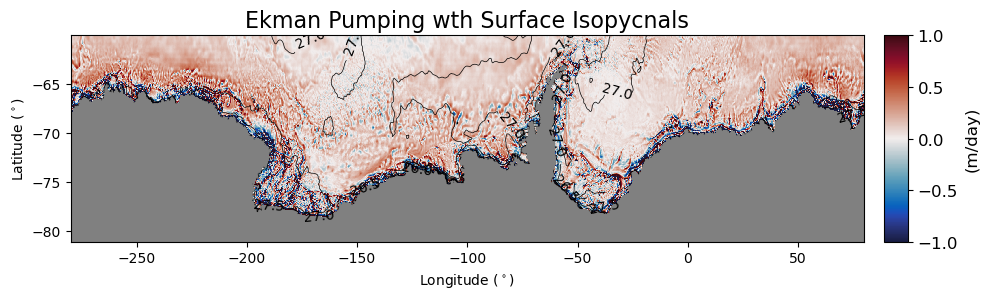

In [14]:
fontsize=12
levels=np.arange(24., 29., 0.5)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
#plt.gca().patch.set_color('.75')
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekp.sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-1,vmax=1)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.title('Ekman Pumping wth Surface Isopycnals',fontsize = 16)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'(m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()


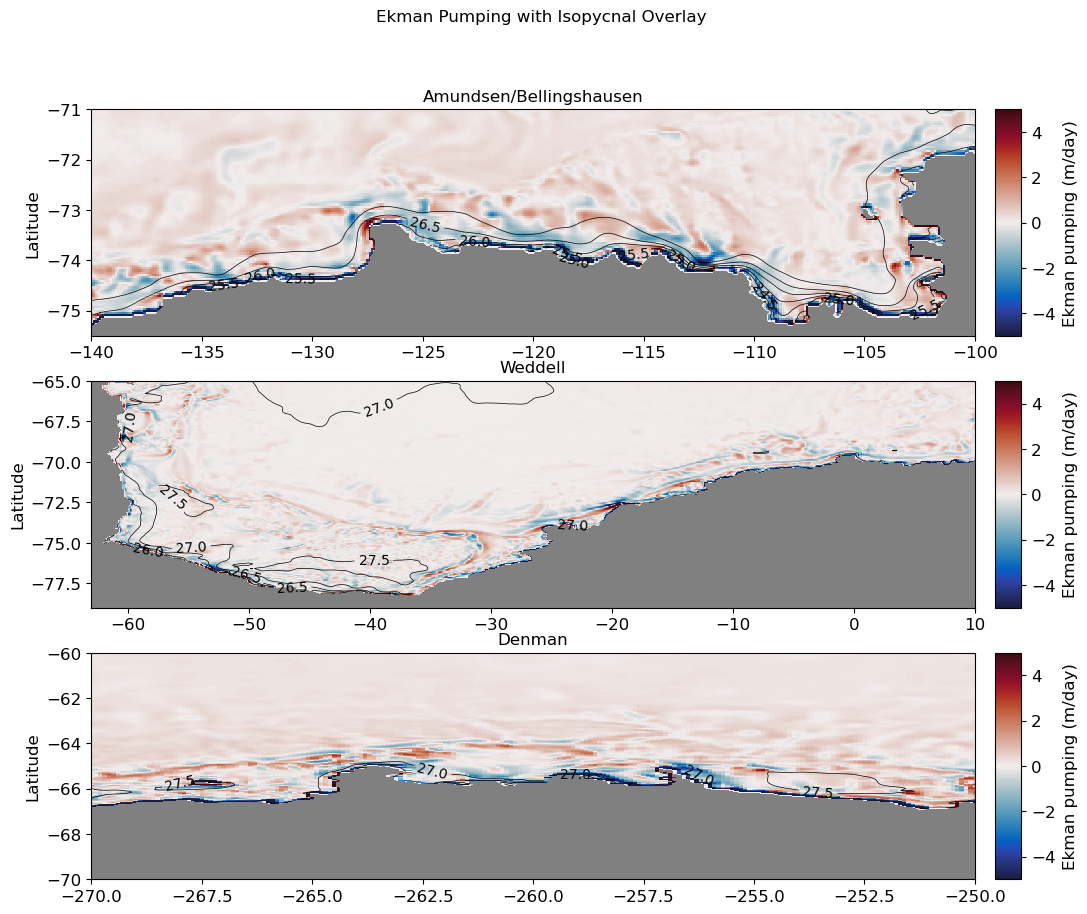

In [15]:
fontsize=12
levels=np.arange(24., 29., 0.5)

plt.figure(figsize=(12,10))
plt.suptitle('Ekman Pumping with Isopycnal Overlay')

plt.subplot(3,1,1)
#plt.gca().patch.set_color('.75')
plt.title('Amundsen/Bellingshausen',fontsize=fontsize)
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekp.sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
#plt.gca().patch.set_color('.5')
plt.title('Weddell',fontsize=fontsize)
plt.ylim([-79,-65])
plt.xlim([-63,10])
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekp.sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')


# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,3)
#plt.gca().patch.set_color('.5')
plt.title('Denman',fontsize=fontsize)
plt.ylim([-70,-60])
plt.xlim([-270,-250])
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekp.sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')


# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)



In [43]:
for tt in range(n_years):
    start_t = str(time_yearly[tt]) + '-01-01'
    end_t   = str(time_yearly[tt]) + '-12-31'
    
    ek_tmp = ekp.sel(time=slice(start_t, end_t))
    pot_rho_0_tmp = pot_rho_0.sel(time=slice(start_t, end_t))
    
    print(ek_tmp.shape,pot_rho_0_tmp.shape)
    

(12, 490, 3600) (12, 490, 3600)
(12, 490, 3600) (12, 490, 3600)
(12, 490, 3600) (12, 490, 3600)
(12, 490, 3600) (12, 490, 3600)
(12, 490, 3600) (12, 490, 3600)
(12, 490, 3600) (12, 490, 3600)
(12, 490, 3600) (12, 490, 3600)


# Density binning sigma0:

In [44]:
# Density binning sigma0:

# Alter if density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
# sigma1:
#isopycnal_bins = np.arange(32.25, 32.75, 0.01) 
# sigma0:
#isopycnal_bins = np.arange(27.5, 28.1, 0.04)

bin_bottoms = isopycnal_bins[:-1]

binned_ekman = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(ekman.yt_ocean), len(ekman.xt_ocean))), coords = [bin_bottoms, time_yearly, ekman.yt_ocean, ekman.xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'Ekman pumping in isopycnal bins summed over time')
binned_ekman.chunk({'isopycnal_bins':1})

for tt in range(n_years):
    start_t = str(time_yearly[tt]) + '-01-01'
    end_t   = str(time_yearly[tt]) + '-12-31'
    
    ek_tmp = ekp.sel(time=slice(start_t, end_t))
    pot_rho_0_tmp = pot_rho_0.sel(time=slice(start_t, end_t))

    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_0_tmp.where(pot_rho_0_tmp <= isopycnal_bins[i+1]).where(pot_rho_0_tmp > isopycnal_bins[i]) * 0 + 1
        masked_ekman = (ek_tmp * bin_mask).sum(dim = 'time') 
        masked_ekman = masked_ekman.where(masked_ekman != 0) 
        masked_ekman = masked_ekman.load()
        binned_ekman[i,tt,:,:] = masked_ekman
        
    print('Year %i done'%time_yearly[tt])

Year 2150 done
Year 2151 done
Year 2152 done
Year 2153 done
Year 2154 done
Year 2155 done
Year 2156 done


# calculate Ekman sigma0:

In [45]:
# calculate Ekman sigma0:
isopycnal_bin_diff  = np.diff(isopycnal_bins)
isopycnal_bin_mid   = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

# Will be overwritten in loop, this is just to get the dimensions etc
ekman_sigma0 = binned_ekman

ekman_tmp = binned_ekman / 365. #for n_days_array


# This procedure defines fluxes from lighter to denser classes as negative, we want the opposite
# Mistake, -1 is not needed for Ekman, but for SWMT
ekman_sigma0 = -1*ekman_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]

# Convert the binned (and summed through time) salt and heat transformation DataArrays to Datasets (to save metadata) and save to netCDF
#ds = xr.Dataset({'binned_salt_transformation': salt_transformation})
#ds = xr.Dataset({'binned_heat_transformation': heat_transformation})

#############################################################
#ekman_control = ekman_sigma0 
#############################################################

# Rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
ekman_sigma0.coords['isopycnal_bins'] = isopycnal_bin_mid

ds = xr.Dataset({'ekman_sigma0': ekman_sigma0})
outpath = ekfo+time_period+'.nc'
ds.to_netcdf(outpath)